# Application of Equation Learner Network via nnodely

This tutorial implements a simple application of the equation learner network.
The techniques is introduced in the paper titled:

*Learning and extrapolation of robotic skills using task-parameterized equation learner networks*

(available at https://doi.org/10.1016/j.robot.2022.104309)


In [1]:
from nnodely import *
import torch

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.1 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Creation of the network with one input x and two outputs y and dy/dx.

In [2]:
t = Input('t')
y = Input('y')
target = Input('target')

linear_in = Linear(output_dimension=7, W='in_W', b='in_b')
linear_hidden = Linear(output_dimension=7, W='hidden_W', b='hidden_b')
linear_out = Linear(output_dimension=1, W='out_W', b='out_b')

def sigma(x):
    return 1/(1+torch.exp(-x))
sigma_fun = ParamFun(param_fun=sigma)

equation_learner = EquationLearner(functions=[Identity, Sin, Cos, sigma_fun, Mul, Sech], linear_in=linear_in)
equation_learner2 = EquationLearner(functions=[Identity, Sin, Cos, sigma_fun, Mul, Sech],linear_in=linear_hidden, linear_out=linear_out)

eq1 = equation_learner(inputs=(t.last(), y.last()))
eq2 = equation_learner2(eq1)
out = Output('out', eq2)

Creation of the Modely model for the Sobolev network


In [3]:
eqL = Modely(visualizer=TextVisualizer())
eqL.addModel('equation_learner',[out])
eqL.addMinimize('error', out, target.last())
eqL.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {},
 'Functions': {'FParamFun13': {'code': 'def sigma(x):\n'
                                       '    return 1/(1+torch.exp(-x))\n',
                               'in_dim': [{'dim': 1, 'sw': 1}],
                               'map_over_dim': False,
                               'n_input': 1,
                               'name': 'sigma',
                               'params_and_consts': []}},
 'Info': {'SampleTime': 1,
          'nnodely_version': '1.5.1',
          'ns': [1, 0],
          'ntot': 1,
          'num_parameters': 77},
 'Inputs': {'t': {'dim': 1, 'ns': [1, 0], 'ntot': 1, 'sw': [-1, 0]},
            'target': {'dim': 1, 'ns': [1, 0], 'ntot': 1, 'sw': [-1, 0]},
            'y': {'dim': 1, 'ns': [1, 0], 'ntot': 1, 'sw': [-1, 0]}},
 'Minimizers': {'error': {'A': 'Linear43', 'B': 'SamplePart45', 'loss': 'mse'}},
 'Models': 'equation_learner',
 'Outputs': {'out': 'Linear43'},

Creation of the dataset and loading

In [4]:
def func(t, y):
    return -0.024*(t**2) -0.064*(y**2) +0.064*t -0.112*y*t +0.256*y -0.5*torch.cos(1.2*t -0.15*y -1.8) -0.2*torch.sin(-1.4*y -0.8) +1.3*sigma(1.4*t +0.5*y)

## Create dataset
gamma_values = torch.linspace(0, 3, 21)
dataset = {'t': [], 'y': [], 'target': []}
for gamma in gamma_values:
    t_values = torch.rand(200)*10
    for t in t_values:
        dataset['t'].append(t)
        dataset['y'].append(gamma)
        dataset['target'].append(func(t, gamma))

eqL.loadData(name='dataset', source=dataset)

============================ nnodely Model Dataset =============================
Dataset Name:                 dataset
Number of files:              1
Total number of samples:      4200
Shape of target:              (4200, 1, 1)
Shape of y:                   (4200, 1, 1)
Shape of t:                   (4200, 1, 1)


In [10]:
optimizer_defaults = {'weight_decay': 0.02,}
eqL.trainModel(train_dataset='dataset', lr=0.004, num_of_epochs=500, optimizer_defaults=optimizer_defaults)

======================== nnodely Model Train Parameters ========================
models:                       ['equation_learner']
num of epochs:                500
update per epochs:            32
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
train dataset:                dataset
	- batch size:                128
	- num of samples:            4200
minimizers:                   {'error': {'A': 'Linear43',
                                         'B': 'SamplePart45',
                                         'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.004, 'weight_decay': 0.02}
optimizer params:             [{'params': 'hidden_W'},
                               {'params': 'hidden_b'},
                               {'params': 'in_W'},
                               {'params': 'in_b'},
                               {'params': 'out_W'},
                               {'params': 'out_b'}]
================= nnodely T

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

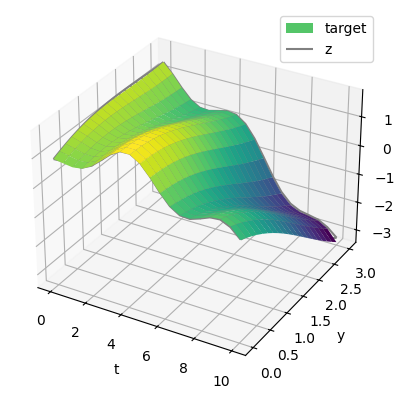

In [ ]:
# Custom visualizer for results
class FunctionVisualizer(TextVisualizer):
    def showResults(self):
        import torch
        import numpy as np
        import matplotlib.pyplot as plt
        plt.figure()
        t = np.linspace(0, 10, 20)
        y = np.linspace(0, 3, 20)
        t, y = np.meshgrid(t, y)
        target = func(torch.tensor(t), torch.tensor(y)).numpy()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(t, y, target, cmap='viridis', label='target')

        z = np.array(self.modely({'t': t.flatten().tolist(), 'y':y.flatten().tolist()})['out']).reshape(t.shape)
        ax.plot_wireframe(t, y, z, color='gray', label='z')

        plt.grid(True)
        plt.legend(loc='best')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.show()

res = FunctionVisualizer()
res.setModely(eqL)
res.showResults()